In [1]:
# %% [markdown]
# # SAM Training Notebook
# Converted from Python script for interactive execution in Jupyter.
# 
# This notebook preserves the original script logic and allows step-by-step debugging.

# %% [code]
import os
import time
import random
import argparse

import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from matplotlib import cm

import lightning as L
from lightning.fabric.loggers import TensorBoardLogger
from lightning.fabric.fabric import _FabricOptimizer

from box import Box
from datasets import call_load_dataset
from utils.model import Model
from utils.eval_utils import AverageMeter, validate, get_prompts, calc_iou
from utils.tools import copy_model, create_csv, reduce_instances
from utils.utils import *

/home/tic/miniconda3/envs/cvpr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %% [markdown]
# ## Training Function

# %% [code]
def train_sam(cfg: Box,
              fabric: L.Fabric,
              model: Model,
              optimizer: _FabricOptimizer,
              scheduler: _FabricOptimizer,
              train_dataloader: DataLoader,
              val_dataloader: DataLoader,
              target_pts):
    model.eval()

    save_dir = "entropy_sorted"
    os.makedirs(save_dir, exist_ok=True)

    collected = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(target_pts, desc='Computing per-sample entropy', ncols=100)):
            imgs, boxes, masks, img_paths = batch
            prompts = get_prompts(cfg, boxes, masks)
            embeds, masks_pred, _, _ = model(imgs, prompts)

            batch_size = imgs.shape[0]
            for b in range(batch_size):
                img_np = (imgs[b].permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
                p_b = masks_pred[b].clamp(1e-6, 1 - 1e-6)
                if p_b.ndim == 2:
                    p_b = p_b.unsqueeze(0)
                gt_b = masks[b]
                if gt_b.ndim == 2:
                    gt_b = gt_b.unsqueeze(0)

                entropy_scalar = 0
                num_inst = p_b.shape[0]
                for j in range(num_inst):
                    p_inst = p_b[j]
                    entropy_map_inst = - (p_inst * torch.log(p_inst) + (1 - p_inst) * torch.log(1 - p_inst))
                    entropy_scalar += float(entropy_map_inst.mean().cpu().item())

                entropy_scalar /= num_inst
                render = {
                    'real': img_np,
                    'prompt': prompts
                }
                img_path = img_paths[b] if isinstance(img_paths, (list, tuple)) else img_paths
                collected.append((entropy_scalar, img_path, render))

    collected.sort(key=lambda x: x[0], reverse=True)

    return collected

    

# %% [markdown]
# ## Optimizer and Scheduler Configuration

# %% [code]
def configure_opt(cfg: Box, model: Model):
    def lr_lambda(step):
        if step < cfg.opt.warmup_steps:
            return step / cfg.opt.warmup_steps
        elif step < cfg.opt.steps[0]:
            return 1.0
        elif step < cfg.opt.steps[1]:
            return 1 / cfg.opt.decay_factor
        else:
            return 1 / (cfg.opt.decay_factor**2)

    optimizer = torch.optim.Adam(model.model.parameters(),
                                 lr=cfg.opt.learning_rate,
                                 weight_decay=cfg.opt.weight_decay)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    return optimizer, scheduler





In [3]:
# %% [markdown]
# ## Configuration Loading and Launch

# %% [code]
# Example: set arguments manually here
# Replace with your config module path, e.g. "configs.default_config"
import importlib

CFG_MODULE = "configs.config_nwpu_"
cfg_module = importlib.import_module(CFG_MODULE)
cfg = cfg_module.cfg

# Manually merge updates if needed
cfg.out_dir = "./outputs"
cfg.resume = False

torch.cuda.empty_cache()
torch.set_float32_matmul_precision('high')

# main(cfg)

In [4]:
gpu_ids = [str(i) for i in range(torch.cuda.device_count())]
fabric = L.Fabric(accelerator="auto",
                  devices=len(gpu_ids),
                  strategy="auto",
                  loggers=[TensorBoardLogger(cfg.out_dir)])
fabric.launch()
fabric.seed_everything(1337 + fabric.global_rank)

if fabric.global_rank == 0:
    os.makedirs(os.path.join(cfg.out_dir, "save"), exist_ok=True)
    create_csv(os.path.join(cfg.out_dir, "metrics.csv"), csv_head=cfg.csv_keys)

with fabric.device:
    model = Model(cfg)
    model.setup()

load_datasets = call_load_dataset(cfg)
train_data, val_data, pt_data = load_datasets(cfg, img_size=1024, return_pt=True)
train_data = fabric._setup_dataloader(train_data)
val_data = fabric._setup_dataloader(val_data)
pt_data = fabric._setup_dataloader(pt_data)

optimizer, scheduler = configure_opt(cfg, model)
model, optimizer = fabric.setup(model, optimizer)

if cfg.resume and cfg.model.ckpt is not None:
    full_checkpoint = fabric.load(cfg.model.ckpt)
    model.load_state_dict(full_checkpoint["model"])
    optimizer.load_state_dict(full_checkpoint["optimizer"])

collected = train_sam(cfg, fabric, model, optimizer, scheduler, train_data, val_data, pt_data)



Global seed set to 1337


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Computing per-sample entropy: 100%|███████████████████████████████| 520/520 [07:18<00:00,  1.19it/s]


In [5]:
# _, _, = validate(fabric, cfg, model, val_data, name=cfg.name, epoch=0)

In [5]:
def prompt_calibration(cfg, entrop_map, prompts, point_status):
    point_list = []
    point_labels_list = []
    num_points = cfg.num_points

    for m in range(len(entrop_map)):
        point_coords = prompts[0][0][m][:].unsqueeze(0)
        point_coords_lab = prompts[0][1][m][:].unsqueeze(0)

        # Find high-entropy location
        max_idx = torch.argmax(entrop_map[m])
        y = max_idx // entrop_map[m].shape[1]
        x = max_idx % entrop_map[m].shape[1]
        neg_point_coords = torch.tensor([[x.item(), y.item()]], device=point_coords.device).unsqueeze(0)


        # Combine positive and negative points
        point_coords_all = torch.cat((point_coords, neg_point_coords), dim=1)
        
        # Append a new label (1) to the label tensor
        point_labels_all = torch.cat(
            (point_coords_lab, torch.tensor([[point_status]], device=point_coords.device, dtype=point_coords_lab.dtype)),
            dim=1
        )
        
        point_list.append(point_coords_all)
        point_labels_list.append(point_labels_all)



    point_ = torch.cat(point_list).squeeze(1)
    point_labels_ = torch.cat(point_labels_list)
    new_prompts = [(point_, point_labels_)]
    return new_prompts


In [14]:
import torch

def entropy_map_calculate(p, eps=1e-8):
    # Clamp to avoid log(0)
    p = torch.clamp(p, eps, 1 - eps)
    
    # Compute binary entropy
    entropy_map = - (p * torch.log(p) + (1 - p) * torch.log(1 - p))
    
    # Normalize to 0–1 (since max entropy = log(2))
    entropy_map = entropy_map / torch.log(torch.tensor(2.0))
    
    return entropy_map


In [15]:
def process_forward(img_tensor, prompt):
    with torch.no_grad():
        _, masks_pred, _, _ = model(img_tensor, prompt)
    entropy_maps = []
    pred_ins = []
    for i, mask_p in enumerate( masks_pred[0]):

        p = mask_p.clamp(1e-6, 1 - 1e-6)
        if p.ndim == 2:
            p = p.unsqueeze(0)

        entropy_map = entropy_map_calculate(p)
        entropy_maps.append(entropy_map)
        pred_ins.append(p)

    return entropy_maps, pred_ins
        
        
        
    

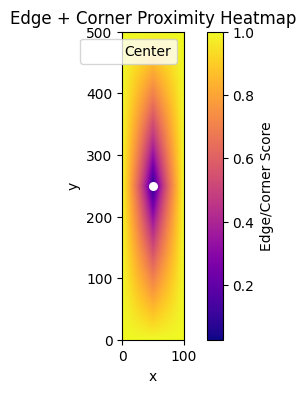

In [87]:
import torch
import matplotlib.pyplot as plt

def edge_corner_score(x, y, x_c, y_c, w, h, gamma=1.0):
    dx = 2 * torch.abs(x - x_c) / w
    dy = 2 * torch.abs(y - y_c) / h
    dx = torch.clamp(dx, 0, 1)
    dy = torch.clamp(dy, 0, 1)
    score = (dx + dy - dx * dy) ** gamma
    return score

# Rectangle parameters
w, h = 100, 500
x_c, y_c = w / 2, h / 2

# Create grid of coordinates
x = torch.linspace(0, w, 400)
y = torch.linspace(0, h, 300)
xx, yy = torch.meshgrid(x, y, indexing="xy")

# Compute edge/corner score over the grid
score_map = edge_corner_score(xx, yy, x_c, y_c, w, h, gamma=0.7)

# Plot the heatmap
plt.figure(figsize=(6,4))
plt.imshow(score_map.numpy(), origin="lower", cmap="plasma", extent=[0, w, 0, h])
plt.colorbar(label="Edge/Corner Score")
plt.title("Edge + Corner Proximity Heatmap")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter([x_c], [y_c], c="white", s=30, label="Center")
plt.legend()
plt.show()


In [70]:

def edge_corner_score(x, y, x_c, y_c, w, h, gamma=0.7):
    dx = 2 * torch.abs(x - x_c) / w
    dy = 2 * torch.abs(y - y_c) / h
    dx = torch.clamp(dx, 0, 1)
    dy = torch.clamp(dy, 0, 1)
    # high on edges + corners, low at center
    score = (dx + dy - dx * dy) ** gamma
    return score


In [92]:
import os
import torch
import numpy as np
import cv2

save_dir = "entropy_sorted"
os.makedirs(save_dir, exist_ok=True)

W, H = 1024, 1024

for rank, (entropy_scalar, img_path, render) in enumerate(collected, start=1):
    img_name = os.path.splitext(os.path.basename(img_path))[0]

    # ---- Convert and move to device
    img_np = render['real']        # numpy HxWx3
    img_tensor = torch.from_numpy(img_np).permute(2,0,1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(fabric.device)

    prompt_main = render['prompt']
    # ---- Forward pass to get entropy + predictions
    entropy_maps, preds = process_forward(img_tensor, prompt_main)

    print(prompt_main[0][0].shape)
    pred_stack = torch.stack(preds, dim=0)

    # Convert to binary masks (e.g., threshold 0.99 as you do)
    pred_binary = (pred_stack > 0.99).float() 
    # Count overlaps
    overlap_count = pred_binary.sum(dim=0)  # (1,1024,1024)
    
    # Optional: extract overlapping region mask (for debugging)
    overlap_map = (overlap_count > 1).float()
    invert_overlap_map = 1.0 - overlap_map
    
    # Convert to uint8 for visualization/saving
    # non_overlap_vis = (non_overlap_map[0].cpu().numpy() * 255).astype(np.uint8)
    

    # # ---- Save the original image once
    img_save_path = os.path.join(save_dir, f"{rank:04d}_{img_name}_image.jpg")
    cv2.imwrite(img_save_path, cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))

    # ---- Loop over instances (each mask + entropy)
    for i, (entr_map, pred) in enumerate(zip(entropy_maps, preds)):
        # # Normalize entropy 0–1
        # entr_norm = (entr_map - entr_map.min()) / (entr_map.max() - entr_map.min() + 1e-8)

        # # Convert to uint8
        # entr_vis = (entr_norm[0].cpu().numpy() * 255).astype(np.uint8)
        pred = (pred[0]>0.99) 
        pred_w_overlap = pred * invert_overlap_map[0]

        

        
        # Find where mask == 1
        ys, xs = torch.where(pred_w_overlap > 0.5)
        if len(xs) > 0 and len(ys) > 0:
            x_min, x_max = xs.min().item(), xs.max().item()
            y_min, y_max = ys.min().item(), ys.max().item()
            h, w = y_max - y_min, x_max - x_min
            print(f"Bounding box: ({x_min}, {y_min}) → ({x_max}, {y_max})") 
            cx = (x_min + x_max) / 2.0
            cy = (y_min + y_max) / 2.0
            # # Optional: draw rectangle
            # mask_vis = (pred_w_overlap.cpu().numpy() * 255).astype(np.uint8)
            # mask_rgb = cv2.cvtColor(mask_vis, cv2.COLOR_GRAY2BGR)
            # cv2.rectangle(mask_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            # pred_path = os.path.join(save_dir, f"{rank:04d}_{img_name}_{i}mask_with_box.png")
            # cv2.imwrite(pred_path, mask_rgb)
        else:
            print("No 1s found in mask")
        # Make sure both tensors are on same device
        point_ref = torch.tensor([cx, cy], dtype=torch.float32, device=prompt_main[0][0][i].device)
        score = edge_corner_score(prompt_main[0][0][i][0][0].item(), prompt_main[0][0][i][0][0].item(), point_ref[0], point_ref[1], w, h)
        
        # point_ref = torch.tensor([cx, cy], dtype=torch.float32, device=prompt_main[0][0][i].device)
        # dist = torch.dist(prompt_main[0][0][i], point_ref)
        print(score)
                

        pred_w_overlap_vis = (pred_w_overlap.cpu().numpy()* 255).astype(np.uint8)
    

        # Save prediction mask
        pred_path = os.path.join(save_dir, f"{rank:04d}_{img_name}_{i}_pred.png")
        cv2.imwrite(pred_path, pred_w_overlap_vis)

    

    print(f"Saved image + {len(entropy_maps)} instance maps for {img_name}")

    # Stop early for testing
    if rank >= 0:
        break


torch.Size([2, 2, 2])
Bounding box: (638, 254) → (829, 781)
tensor(0.8012, device='cuda:0')
Bounding box: (555, 325) → (887, 919)
tensor(0.7942, device='cuda:0')
Saved image + 2 instance maps for 561


In [17]:
save_dir="entropy_sorted"
for rank, (entropy_scalar, img_path, render) in enumerate(reversed(collected), start=1):
    img_tensor = torch.from_numpy(render['real']).permute(2,0,1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(fabric.device)

    prompt_main = render['prompt']

    entropy_maps, preds = process_forward(img_tensor, prompt_main)

    

    prompt_1 = prompt_calibration(cfg, entropy_maps, prompt_main, 1)
    entropy_maps_1, preds_1 = process_forward(img_tensor, prompt_1)
    entr_means_pos = [ent.mean().item() for ent in entropy_maps_1]

    # Compute relative entropy = mean entropy / (number of 1s in prediction)
    rel_entr_pos = []
    for ent, pred in zip(entropy_maps_1, preds_1):
        num_ones = (pred >0.5 ).sum().item()
        rel_entr = ent.mean().item() / num_ones if num_ones > 0 else float('inf')
        rel_entr_pos.append(rel_entr)


    prompt_2 = prompt_calibration(cfg, entropy_maps, prompt_main, 0)
    entropy_maps_2, preds_2 = process_forward(img_tensor, prompt_2)
    entr_means_neg = [ent.mean().item() for ent in entropy_maps_2]

    rel_entr_neg = []
    for ent, pred in zip(entropy_maps_2, preds_2):
        num_ones = (pred == 0.5).sum().item()
        rel_entr = ent.mean().item() / num_ones if num_ones > 0 else float('inf')
        rel_entr_neg.append(rel_entr)

    pred_final = []
    
    
    for i in range(len(preds_1)):
        if rel_entr_pos[i] < rel_entr_neg[i]:
            pred_final.append(preds_1[i])
        else:
            pred_final.append(preds_2[i])
        
   
    # for i,p in  enumerate(pred_final):
    #     pred_mask = p.max(dim=0)[0]
    #     pred_bin = (pred_mask > 0.5).to(torch.uint8).cpu().numpy() * 255


    
    #     base = os.path.splitext(os.path.basename(img_path))[0]
    #     suffix = f"{rank:05d}_{base}"
        
    #     Image.fromarray(pred_bin).save(os.path.join(save_dir, f"{suffix}{i}_pred.jpg"))
    #     # Image.fromarray(entropy_color).save(os.path.join(save_dir, f"{suffix}{i}_en.jpg"))

    # Combine all pseudo-label predictions into one final mask
    pred_stack = torch.stack([
        (p.max(dim=0)[0] if p.ndim == 3 else p) for p in pred_final
    ])
    final_mask = pred_stack.mean(dim=0)  # or .max(dim=0)[0] for union
    # Convert to binary pseudo label
    final_bin = (final_mask > 0.06).to(torch.uint8).cpu().numpy() * 255

    # Save combined pseudo-label
    base = os.path.splitext(os.path.basename(img_path))[0]
    suffix = f"{rank:05d}_{base}"
    Image.fromarray(final_bin).save(os.path.join(save_dir, f"{suffix}_pseudo_combined.jpg"))


    # Combine all pseudo-label predictions into one final mask
    pred_first = torch.stack([
        (p.max(dim=0)[0] if p.ndim == 3 else p) for p in preds
    ])
    final_mask = pred_first.mean(dim=0)  # or .max(dim=0)[0] for union
    # Convert to binary pseudo label
    final_bin_p = (final_mask > 0.06).to(torch.uint8).cpu().numpy() * 255

    # Save combined pseudo-label
    base = os.path.splitext(os.path.basename(img_path))[0]
    suffix = f"{rank:05d}_{base}"
    Image.fromarray(final_bin_p).save(os.path.join(save_dir, f"{suffix}_pred_combined.jpg"))
    

    
    Image.fromarray(render['real']).save(os.path.join(save_dir, f"{suffix}.jpg"))


    if rank>400:
        break

    

    

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 5.68 GiB of which 204.12 MiB is free. Including non-PyTorch memory, this process has 5.46 GiB memory in use. Of the allocated memory 4.21 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
save_dir="entropy_sorted"

for rank, (entropy_scalar, img_path, render) in enumerate(collected, start=1):
    img_tensor = torch.from_numpy(render['real']).permute(2,0,1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(fabric.device)

    prompt_b = render['prompt']


    with torch.no_grad():
        _, masks_pred, _, _ = model(img_tensor, prompt_b)



    entropy_maps = []
    for i, mask_pred in enumerate( masks_pred[0]):
  

        p = mask_pred.clamp(1e-6, 1 - 1e-6)
        if p.ndim == 2:
            p = p.unsqueeze(0)
    
        entropy_map = - (p * torch.log(p) + (1 - p) * torch.log(1 - p))
        entropy_map = entropy_map.max(dim=0)[0]
        pred_mask = p.max(dim=0)[0]
        pred_bin = (pred_mask > 0.5).to(torch.uint8).cpu().numpy() * 255

        entropy_maps.append(entropy_map)
    
        entropy_np = entropy_map.cpu().numpy()
        entropy_norm = (entropy_np - entropy_np.min()) / (entropy_np.max() - entropy_np.min() + 1e-6)
        cmap = cm.get_cmap("viridis")
        entropy_color = (cmap(entropy_norm)[:, :, :3] * 255).astype(np.uint8)

    
        base = os.path.splitext(os.path.basename(img_path))[0]
        suffix = f"{rank:05d}_{base}"
        Image.fromarray(render['real']).save(os.path.join(save_dir, f"{suffix}{i}.jpg"))
        Image.fromarray(pred_bin).save(os.path.join(save_dir, f"{suffix}{i}_pred.jpg"))
        Image.fromarray(entropy_color).save(os.path.join(save_dir, f"{suffix}{i}_en.jpg"))
    new_prom = neg_prompt_calibration(cfg, entropy_maps, prompt_b) 


    # with torch.no_grad():
    #     _, masks_pred, _, _ = model(img_tensor, new_prom)

    # entropy_maps = []
    # for i, mask_pred in enumerate( masks_pred[0]):
  

    #     p = mask_pred.clamp(1e-6, 1 - 1e-6)
    #     if p.ndim == 2:
    #         p = p.unsqueeze(0)
    
    #     entropy_map = - (p * torch.log(p) + (1 - p) * torch.log(1 - p))
    #     entropy_map = entropy_map.max(dim=0)[0]
    #     pred_mask = p.max(dim=0)[0]
    #     pred_bin = (pred_mask > 0.5).to(torch.uint8).cpu().numpy() * 255

    #     entropy_maps.append(entropy_map)
    
    #     entropy_np = entropy_map.cpu().numpy()
    #     entropy_norm = (entropy_np - entropy_np.min()) / (entropy_np.max() - entropy_np.min() + 1e-6)
    #     cmap = cm.get_cmap("viridis")
    #     entropy_color = (cmap(entropy_norm)[:, :, :3] * 255).astype(np.uint8)

    
    #     base = os.path.splitext(os.path.basename(img_path))[0]
    #     suffix = f"{rank:05d}_{base}"
    #     Image.fromarray(render['real']).save(os.path.join(save_dir, f"{suffix}{i}_a.jpg"))
    #     Image.fromarray(pred_bin).save(os.path.join(save_dir, f"{suffix}{i}_pred_a.jpg"))
    #     Image.fromarray(entropy_color).save(os.path.join(save_dir, f"{suffix}{i}_en_a.jpg"))

    
    if rank>0:
        break